# Adversarial-Robustness-Toolbox for LightGBM

In [1]:
import lightgbm as lgb

from sklearn.datasets import load_iris

import numpy as np
from matplotlib import pyplot as plt

from art.classifiers import LightGBMClassifier
from art.attacks import ZooAttack
from art.utils import load_mnist

import warnings
warnings.filterwarnings('ignore')

## 1 Training LighGBM classifier and attacking with ART Zeroth Order Optimization attack

In [2]:
def get_adversarial_examples(x_train, y_train, num_classes):
    
    # Create and fit LightGBM model
    num_round = 10
    param = {'objective': 'multiclass', 'metric': 'multi_logloss', 'num_class': num_classes}
    train_data = lgb.Dataset(x_train, label=y_train)
    model = lgb.train(param, train_data, num_round, valid_sets=[])

    # Create ART classifier for LightGBM
    art_classifier = LightGBMClassifier(model=model)

    # Create ART Zeroth Order Optimization attack
    zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=20,
                    binary_search_steps=10, initial_const=1e-3, abort_early=True, use_resize=False, 
                    use_importance=False, nb_parallel=1, batch_size=1, variable_h=0.2)

    # Generate adversarial samples with ART Zeroth Order Optimization attack
    x_train_adv = zoo.generate(x_train)

    return x_train_adv, model

## 1.1 Utility functions

In [3]:
def get_data(num_classes):
    x_train, y_train = load_iris(return_X_y=True)
    x_train = x_train[y_train < num_classes][:, [0, 1]]
    y_train = y_train[y_train < num_classes]
    x_train[:, 0][y_train == 0] *= 2
    x_train[:, 1][y_train == 2] *= 2
    x_train[:, 0][y_train == 0] -= 3
    x_train[:, 1][y_train == 2] -= 2
    
    x_train[:, 0] = (x_train[:, 0] - 4) / (9 - 4)
    x_train[:, 1] = (x_train[:, 1] - 1) / (6 - 1)
    
    return x_train, y_train

In [4]:
def plot_results(model, x_train, y_train, x_train_adv, num_classes):
    
    fig, axs = plt.subplots(1, num_classes, figsize=(num_classes * 5, 5))

    colors = ['orange', 'blue', 'green']

    for i_class in range(num_classes):

        # Plot difference vectors
        for i in range(y_train[y_train == i_class].shape[0]):
            x_1_0 = x_train[y_train == i_class][i, 0]
            x_1_1 = x_train[y_train == i_class][i, 1]
            x_2_0 = x_train_adv[y_train == i_class][i, 0]
            x_2_1 = x_train_adv[y_train == i_class][i, 1]
            if x_1_0 != x_2_0 or x_1_1 != x_2_1:
                axs[i_class].plot([x_1_0, x_2_0], [x_1_1, x_2_1], c='black', zorder=1)

        # Plot benign samples
        for i_class_2 in range(num_classes):
            axs[i_class].scatter(x_train[y_train == i_class_2][:, 0], x_train[y_train == i_class_2][:, 1], s=20,
                                 zorder=2, c=colors[i_class_2])
        axs[i_class].set_aspect('equal', adjustable='box')

        # Show predicted probability as contour plot
        h = .01
        x_min, x_max = 0, 1
        y_min, y_max = 0, 1

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        Z_proba = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z_proba = Z_proba[:, i_class].reshape(xx.shape)
        im = axs[i_class].contourf(xx, yy, Z_proba, levels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                   vmin=0, vmax=1)
        if i_class == num_classes - 1:
            cax = fig.add_axes([0.95, 0.2, 0.025, 0.6])
            plt.colorbar(im, ax=axs[i_class], cax=cax)

        # Plot adversarial samples
        for i in range(y_train[y_train == i_class].shape[0]):
            x_1_0 = x_train[y_train == i_class][i, 0]
            x_1_1 = x_train[y_train == i_class][i, 1]
            x_2_0 = x_train_adv[y_train == i_class][i, 0]
            x_2_1 = x_train_adv[y_train == i_class][i, 1]
            if x_1_0 != x_2_0 or x_1_1 != x_2_1:
                axs[i_class].scatter(x_2_0, x_2_1, zorder=2, c='red', marker='X')
        axs[i_class].set_xlim((x_min, x_max))
        axs[i_class].set_ylim((y_min, y_max))

        axs[i_class].set_title('class ' + str(i_class))
        axs[i_class].set_xlabel('feature 1')
        axs[i_class].set_ylabel('feature 2')

# 2 Example: Iris dataset

### legend
- colored background: probability of class i
- orange circles: class 1
- blue circles: class 2
- green circles: class 3
- red crosses: adversarial samples for class i

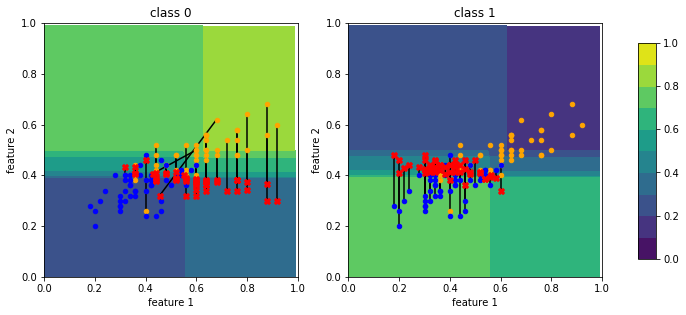

In [5]:
num_classes = 2
x_train, y_train = get_data(num_classes=num_classes)
x_train_adv, model = get_adversarial_examples(x_train, y_train, num_classes)
plot_results(model, x_train, y_train, x_train_adv, num_classes)

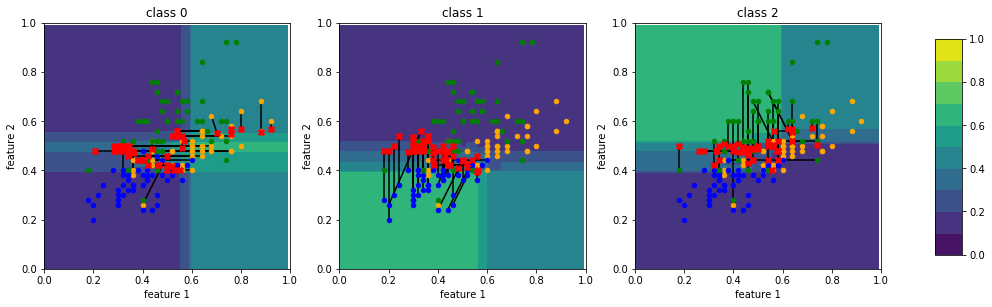

In [6]:
num_classes = 3
x_train, y_train = get_data(num_classes=num_classes)
x_train_adv, model = get_adversarial_examples(x_train, y_train, num_classes)
plot_results(model, x_train, y_train, x_train_adv, num_classes)

# 3 Example: MNIST

## 3.1 Load and transform MNIST dataset

In [7]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_mnist()

n_samples_train = x_train.shape[0]
n_features_train = x_train.shape[1] * x_train.shape[2] * x_train.shape[3]
n_samples_test = x_test.shape[0]
n_features_test = x_test.shape[1] * x_test.shape[2] * x_test.shape[3]

x_train = x_train.reshape(n_samples_train, n_features_train)
x_test = x_test.reshape(n_samples_test, n_features_test)

y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

n_samples_max = 200
x_train = x_train[0:n_samples_max]
y_train = y_train[0:n_samples_max]
x_test = x_test[0:n_samples_max]
y_test = y_test[0:n_samples_max]

## 3.2 Train LightGBMClassifier classifier

In [57]:
num_round = 25
param = {'objective': 'multiclass', 'metric': 'multi_logloss', 'num_class': 10}
train_data = lgb.Dataset(x_train, label=y_train)
validation_data = train_data
model = lgb.train(param, train_data, num_round, valid_sets=[validation_data])

[1]	training's multi_logloss: 2.08117
[2]	training's multi_logloss: 1.9099
[3]	training's multi_logloss: 1.75426
[4]	training's multi_logloss: 1.61072
[5]	training's multi_logloss: 1.48884
[6]	training's multi_logloss: 1.38206
[7]	training's multi_logloss: 1.28643
[8]	training's multi_logloss: 1.19899
[9]	training's multi_logloss: 1.11667
[10]	training's multi_logloss: 1.03082
[11]	training's multi_logloss: 0.958193
[12]	training's multi_logloss: 0.890689
[13]	training's multi_logloss: 0.827041
[14]	training's multi_logloss: 0.772012
[15]	training's multi_logloss: 0.719107
[16]	training's multi_logloss: 0.669513
[17]	training's multi_logloss: 0.624627
[18]	training's multi_logloss: 0.581928
[19]	training's multi_logloss: 0.542164
[20]	training's multi_logloss: 0.505364
[21]	training's multi_logloss: 0.472722
[22]	training's multi_logloss: 0.440549
[23]	training's multi_logloss: 0.413029
[24]	training's multi_logloss: 0.384772
[25]	training's multi_logloss: 0.359488


## 3.3 Create and apply Zeroth Order Optimization Attack with ART

In [58]:
art_classifier = LightGBMClassifier(model=model)

In [74]:
zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=100,
                binary_search_steps=100, initial_const=1e-3, abort_early=True, use_resize=False, 
                use_importance=False, nb_parallel=10, batch_size=1, variable_h=0.25)

In [75]:
x_train_adv = zoo.generate(x_train)

In [76]:
x_test_adv = zoo.generate(x_test)

## 3.4 Evaluate LightGBMClassifier on benign and adversarial samples

In [77]:
y_pred = model.predict(x_train)
score = np.sum(y_train == np.argmax(y_pred, axis=1)) / y_train.shape[0]
print("Benign Training Score: %.4f" % score)

Benign Training Score: 1.0000


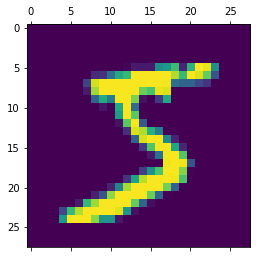

In [78]:
plt.matshow(x_train[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [79]:
prediction = np.argmax(model.predict(x_train[0:1, :]), axis=1)
print("Benign Training Predicted Label: %i" % prediction)

Benign Training Predicted Label: 5


In [80]:
y_pred = model.predict(x_train_adv)
score = np.sum(y_train == np.argmax(y_pred, axis=1)) / y_train.shape[0]
print("Adversarial Training Score: %.4f" % score)

Adversarial Training Score: 0.8450


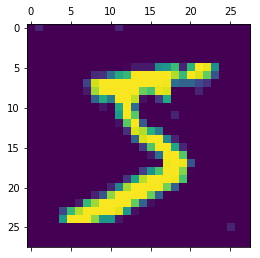

In [81]:
plt.matshow(x_train_adv[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [82]:
prediction = np.argmax(model.predict(x_train_adv[0:1, :]), axis=1)
print("Adversarial Training Predicted Label: %i" % prediction)

Adversarial Training Predicted Label: 3


In [83]:
y_pred = model.predict(x_test)
score = np.sum(y_test == np.argmax(y_pred, axis=1)) / y_test.shape[0]
print("Benign Test Score: %.4f" % score)

Benign Test Score: 0.6700


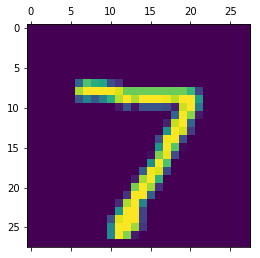

In [84]:
plt.matshow(x_test[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [85]:
prediction = np.argmax(model.predict(x_test[0:1, :]), axis=1)
print("Benign Test Predicted Label: %i" % prediction)

Benign Test Predicted Label: 7


In [86]:
y_pred = model.predict(x_test_adv)
score = np.sum(y_test == np.argmax(y_pred, axis=1)) / y_test.shape[0]
print("Adversarial Test Score: %.4f" % score)

Adversarial Test Score: 0.6150


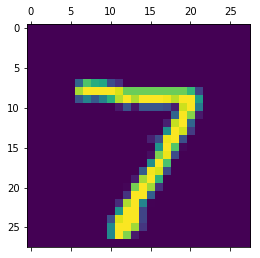

In [87]:
plt.matshow(x_test_adv[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [88]:
prediction = np.argmax(model.predict(x_test_adv[0:1, :]), axis=1)
print("Adversarial Test Predicted Label: %i" % prediction)

Adversarial Test Predicted Label: 7
